# 🧠 03_Explainability.ipynb
Global + Local Explainability for Health Risk Scorecard
## Introduction
In this notebook, we focus on making our improved SDOH Health Risk Scorecard interpretable and transparent. While predictive accuracy is important, explainability is essential for real-world adoption in public health decision-making.

Key objectives include:
- Global explainability using ELI5 Permutation Importance to identify the most influential features driving predictions across the population.
- Local explainability using LIME (Local Interpretable Model-agnostic Explanations) to understand the individual-level drivers behind high-risk predictions.
- Generating both visual and tabular outputs to support explainability across stakeholders — from data scientists to public health officials.

This notebook emphasizes model transparency and interpretability to bridge the gap between ML and actionable public health insights.

In [1]:
# 03_Explainability.ipynb
# Global + Local Explainability for Improved Health Risk Scorecard

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

In [2]:
# ---------------------- # 1. Load Data and Define Target
brfss = pd.read_csv("data/brfss_combined_cleaned.csv")
print("Shape:", brfss.shape)

leak_cols = ['DIABETE3', '_BMI5', '_TOTINDA', '_HLTHPL1']
existing_leaks = [col for col in leak_cols if col in brfss.columns]

y = brfss['HIGH_RISK']
X = brfss.drop(columns=['HIGH_RISK'] + existing_leaks)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include='category').columns.tolist()


Shape: (2380047, 13)


In [3]:
# ---------------------- # 2. Preprocessing + Calibrated XGBoost
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

xgb = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss')
calibrated_clf = CalibratedClassifierCV(xgb, cv=StratifiedKFold(n_splits=3))

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', calibrated_clf)
])

model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]

D:\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ ELI5 global importance saved


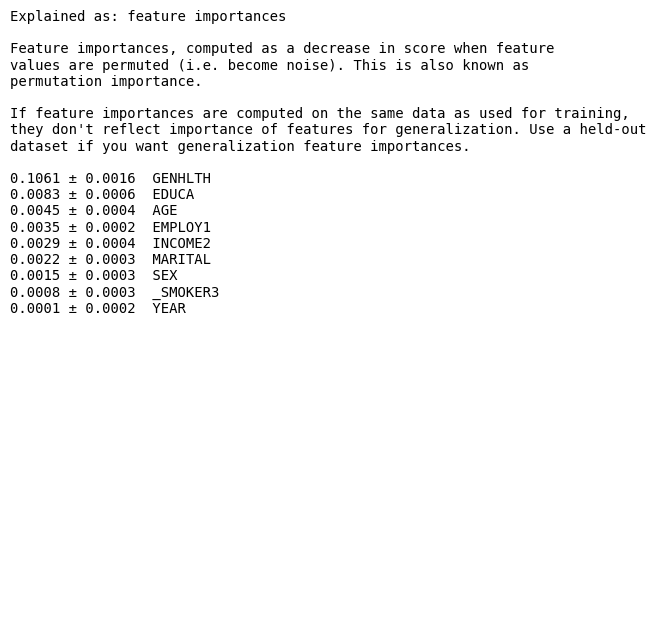

In [4]:
# ---------------------- # 3. Global Explainability - ELI5
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Get final feature names
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoder.fit(X_train[cat_cols])
cat_features = encoder.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_features)

perm = PermutationImportance(model.named_steps['classifier'], random_state=42)
perm.fit(X_test_transformed, y_test)

# Save ELI5 output
os.makedirs("outputs", exist_ok=True)
eli5_html = eli5.format_as_html(eli5.explain_weights(perm, feature_names=feature_names))
with open("outputs/eli5_top_features.html", "w") as f:
    f.write(eli5_html)

top_feats_txt = eli5.format_as_text(eli5.explain_weights(perm, feature_names=feature_names))
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.text(0, 1, top_feats_txt, fontsize=10, family="monospace")
plt.savefig("outputs/eli5_top_features.png", bbox_inches='tight')
print("✅ ELI5 global importance saved")


In [5]:
# ---------------------- # 4. Local Explainability - LIME (Single Sample)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=model.named_steps['preprocessor'].transform(X_train),
    feature_names=feature_names,
    class_names=['Low Risk', 'High Risk'],
    mode='classification'
)

i = 0  # Choose sample index
sample = model.named_steps['preprocessor'].transform(X_test.iloc[[i]])
exp = explainer.explain_instance(sample[0], model.named_steps['classifier'].predict_proba, num_features=10)
exp.save_to_file("outputs/lime_explanation_sample_0.html")
print("✅ LIME explanation (sample 0) saved")


✅ LIME explanation (sample 0) saved


In [6]:
# ---------------------- # 5. Batch LIME Explanations (Top 3 Drivers CSV)
batch_outputs = []
for i in range(100):  # First 100 samples
    sample = model.named_steps['preprocessor'].transform(X_test.iloc[[i]])
    exp = explainer.explain_instance(
        data_row=sample[0],
        predict_fn=model.named_steps['classifier'].predict_proba,
        num_features=10
    )
    lime_weights = exp.as_list()
    top_drivers = [feat for feat, weight in lime_weights if weight > 0][:3]
    batch_outputs.append({
        'Index': i,
        'Top_1': top_drivers[0] if len(top_drivers) > 0 else '',
        'Top_2': top_drivers[1] if len(top_drivers) > 1 else '',
        'Top_3': top_drivers[2] if len(top_drivers) > 2 else ''
    })

lime_df = pd.DataFrame(batch_outputs)
lime_df.to_csv("outputs/lime_top3_drivers_batch.csv", index=False)
print("✅ Saved: outputs/lime_top3_drivers_batch.csv")

✅ Saved: outputs/lime_top3_drivers_batch.csv


## Conclusion: Insights from Explainability
This phase deepened our understanding of the why behind our health risk predictions:
- Global insights (via ELI5) confirmed that general health, education level, and employment status are the most influential drivers of predicted risk.
- Local insights (via LIME) revealed personalized explanations for individual predictions, helping trace top 3 contributing factors per sample.

We saved outputs in multiple formats — HTML, PNG, and CSV — for interactive visualization and downstream integration.
Together, these explainability tools make our ML model more trustworthy, actionable, and ready for integration into decision-support systems in healthcare and policy planning.

